# Spectrum

Script to load a spectrum from PHOENIX and output it as Alfrodull spectrum, resampled to alfrodull input

In [1]:
from ftplib import FTP
import tempfile

from pathlib import Path
import numpy as np

from phoenix import create_interpolated_spectrum
from alfrodull_input_tools import load_opacities_wavelength_bins, rebin_spectrum
#%matplotlib ipympl
%matplotlib inline
import matplotlib.pyplot as plt
import math
import h5py

## Config data

In [2]:
# target data
Teff = 4798
logg = 4.55
FeH = -0.13 
alphaM = 0.0

# opacity input to use for 
opacity_samples_file = Path( "../input/opac_sample_r50.h5" )
opacity_samples_is_CGS = True

# output
output_dir = Path("../input")
resampled_stellar_spectrum_path = output_dir / "stellar_sample_wasp43.h5"

output_phoenix_interpolated_spectrum = False


### Load and interpolate the PHOENIX spectrum

In [3]:
wavelengths, spectrum = create_interpolated_spectrum(Teff, logg, FeH, alphaM)

Retrieving WAVE_PHOENIX-ACES-AGSS-COND-2011.fits from PHOENIX ftp
Retrieving Z-0.5/lte04700-4.50-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits from PHOENIX ftp
Retrieving Z-0.5/lte04800-4.50-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits from PHOENIX ftp
Retrieving Z-0.5/lte04700-5.00-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits from PHOENIX ftp
Retrieving Z-0.5/lte04800-5.00-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits from PHOENIX ftp
Retrieving Z-0.5/lte04700-4.50-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits from PHOENIX ftp
Retrieving Z-0.5/lte04800-4.50-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits from PHOENIX ftp
Retrieving Z-0.5/lte04700-5.00-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits from PHOENIX ftp
Retrieving Z-0.5/lte04800-5.00-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits from PHOENIX ftp
Retrieving Z-0.0/lte04700-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits from PHOENIX ftp
Retrieving Z-0.0/lte04800-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits from PHOENIX ftp
Retrieving Z-0.0/lte0470

### Output the interpolated spectrum

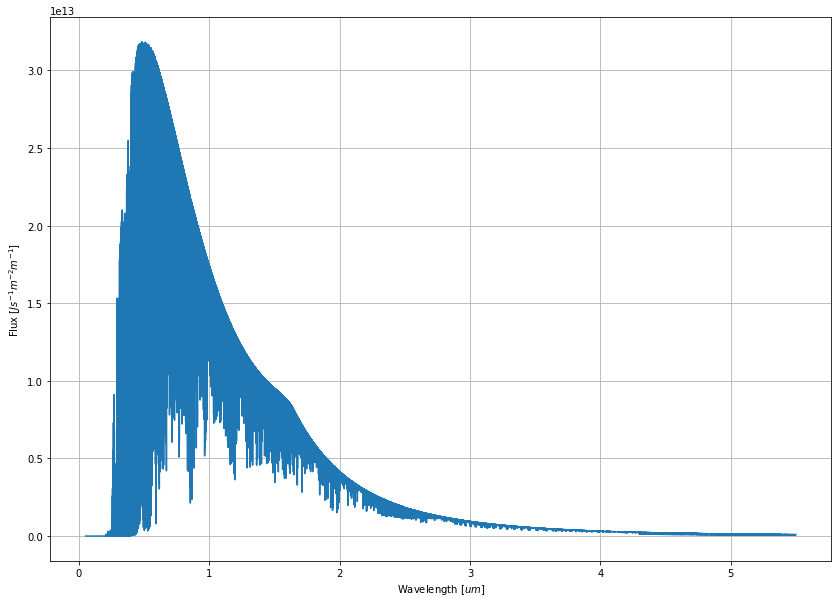

In [4]:
fig, ax = plt.subplots(1,1, figsize=(14,10))

ax.plot(1e6*wavelengths, spectrum)
ax.grid(True)

ax.set_xlabel("Wavelength [$um$]")
ax.set_ylabel("Flux [$J s^{-1} m^{-2} m^{-1}$]")

pass

In [5]:
# to output the phoenix spectrum
if output_phoenix_interpolated_spectrum:
    with h5py.File("interpolated_phoenix_stellar_spectrum.h5", "w") as f:
        lambda_dset = f.create_dataset("wavelength", (len(wavelengths),), dtype=np.float64)        
        flux_dset = f.create_dataset("flux", spectrum.shape, dtype=np.float64)
        lambda_dset[...] = wavelengths
        flux_dset[...] = spectrum


## Load the opacity grid and get the interfaces

In [6]:
opac_wavelengths_centers, opac_wavelength_interfaces = load_opacities_wavelength_bins(opacity_samples_file)

# change wavelength unit to SI
if opacity_samples_is_CGS:
    opac_wavelengths_centers *= 1e-2
    opac_wavelength_interfaces *= 1e-2

print(f"from {opac_wavelength_interfaces[0]} m to {opac_wavelength_interfaces[-1]} m ")

from 3.366000000000001e-07 m to 0.0002018232880594399 m 


## Interpolate stellar spectrum to new interfaces

In [7]:
rebinned_spectrum = rebin_spectrum(opac_wavelength_interfaces, wavelengths, spectrum, Teff)

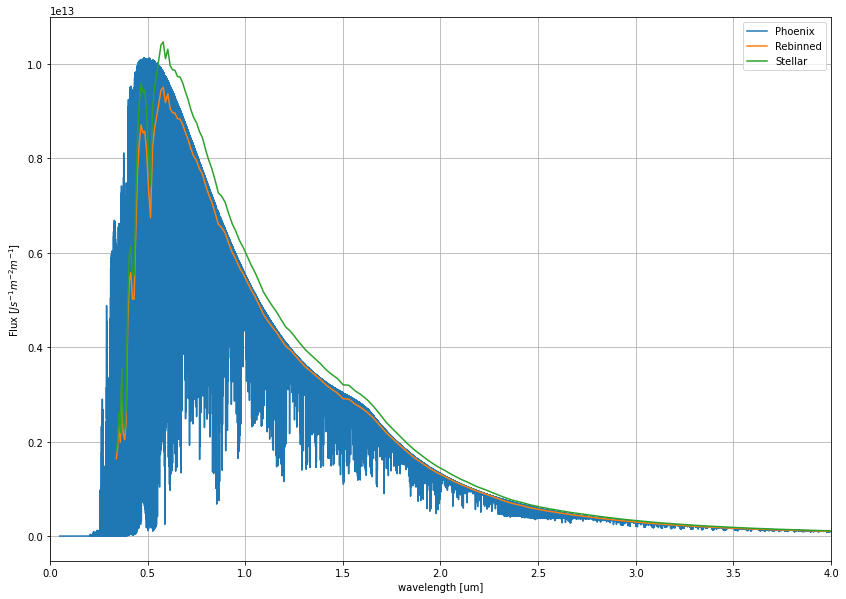

In [9]:
fig, ax = plt.subplots(1,1, figsize=(14,10))

ax.plot(wavelengths*1e6, spectrum, label="Phoenix")
ax.plot(opac_wavelengths_centers*1e6, rebinned_spectrum, label="Rebinned")

ax.grid(True)

ax.set_xlim(0,4)
ax.legend()

ax.set_xlabel("wavelength [um]")
ax.set_ylabel("Flux [$J s^{-1} m^{-2} m^{-1}$]")

pass

In [10]:
with h5py.File(resampled_stellar_spectrum_path, "w") as f:
    lambda_dset = f.create_dataset("wavelength", (len(opac_wavelengths_centers),), dtype=np.float64)
    flux_dset = f.create_dataset("flux", rebinned_spectrum.shape, dtype=np.float64)
    lambda_dset[...] = opac_wavelengths_centers
    flux_dset[...] = rebinned_spectrum